[Open in colab](https://colab.research.google.com/drive/1TG_z6ZpCP9ai6OpOnWg4217FjpwkgiO3)

# 1. Activation distribution for a binary network
We have a binary layer  of neurons **X** of size $N$. Its  state is described as a vector $ \vec{x}=\{0,1\}^N $
There are $a_x$ active neurons randomly distrbuted. 
The layer Y of size $M$ is connected to layer X with binary randomly distributed weights $w$ and each neuron $y_i$ has $a_w$ active weights.
For a linear activation $y_i=\sum_j{w_{ij}x_j}$ find the distribution of activation  $p(y_i=k)$

---


## Solution
To find the probability that a neuron's activation was $k$ we need to estimate the probabilty that exactly $k$ weight connected to active neurons. There are $C^k_{a_x}$ way to chose $k$ connections amoung $a_x$ and $C^{a_w-k}_{N-a_x}$ ways to distribute remaining connections to non active neurons ($N-a_x$). The total number of possible connections is $C^{a_w}_N$, so the probability of having $k$ activation level is: 
$$ p(y_i=k)=\frac{C^k_{a_x}C^{a_w-k}_{N-a_x}}{C^{a_w}_N} $$

where $k=0:k_{max}, k_{max}=min(a_x, a_w)$.

Let's test the solution on python

## Python experiments

In [33]:
import numpy as np

def generate_vector(N, a):
    assert N >= a, 'number of active neurons should be smaller'
    ind = np.random.choice(N, size=a, replace=False)
    vector = np.zeros(N, dtype='uint8')
    vector[ind] = 1
    return vector
  
def generate_matrix((M, N), a):
    assert N >= a, 'number of active neurons in a row should be smaller'
    vector = []
    for i in range(M):
        vector.append(generate_vector(N, a))
    vector = np.array(vector)
    return vector

Here we created functions to generate vectors and matrices with exact number of ones (randomly distributed)

In [39]:
# size of the layers
N=50
M=200
# sparsity of activation
s_x = 0.8
s_w = 0.2

a_x = int(s_x * N)
a_w = int(s_w * N)

k_max = int(min([a_x, a_w]))


x = generate_vector(N, a_x)
w = generate_matrix((N, M), a_w)
k_slide = 3

def get_stat_for_network(iters=100):
    Y = np.zeros((iters, k_max + k_slide))
    for i in range(iters):
        x = generate_vector(N, a_x)
        w = generate_matrix((M, N), a_w)
        Y[i] = np.bincount(np.dot(w, x).astype(int), minlength=k_max + k_slide)

    return np.mean(Y, axis=0)

p_exp = (get_stat_for_network(100)).astype(int)
print(p_exp)

[ 0  0  0  0  0  3 15 43 68 53 16  0  0]


p_exp is not a true probability distribution but multiplied by M. It help to understand the meaning, the avarage number of neurons that have particular activation.  If you noted the solution does not depend on number of neurons in Y layer, but we still use it. Since the neurons are independent and have different weights we can use an ergodic principle (you could run experiments for one neuron many times, or one time for many neurons). But we still added iterations to average result and make it more stable.

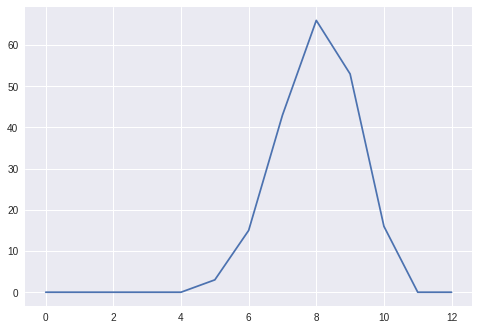

In [40]:
import matplotlib.pyplot as plt

plt.plot(range(k_max + k_slide), (get_stat_for_network(100)).astype(int))
plt.show()

Compare it with the theory

[1.94698777e-08 7.78795109e-06 6.83392708e-04 2.30834870e-02
 3.73663946e-01 3.22845650e+00 1.56938858e+01 4.35585400e+01
 6.73796166e+01 5.32382156e+01 1.65038468e+01]


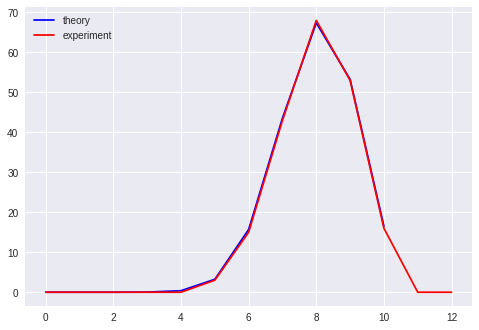

In [42]:
from decimal import Decimal
import math

def C(b, s):
    # number of combinations
    if s == 0 or s == b:
        return 1
    return reduce(lambda x, y: x*y, range(b-s+1,b+1))/math.factorial(s)

  
k_slide = 1  
  
def prob_distr(N, a_x, a_w):
    k_max = min(a_x, a_w)
    p = np.zeros(k_max + k_slide)
    for k in range(k_max + k_slide):
        p[k] = Decimal(C(a_x, k)) * C(N - a_x, a_w - k) / C(N, a_w)
    return p
  
p_theory = prob_distr(N, a_x, a_w)
print(p_theory * M) 

plt.plot(range(p_theory.size), p_theory * M,  'b' , label='theory',)
plt.plot(range(p_exp.size), p_exp, 'r', label='experiment')
plt.legend(loc='upper left')
plt.show()

Result is satisfying.

## Intuition

You can see that some neurons are very active some are not, and the average somewhere in the middle. Depending on the parameters the curve will shift from left (weakly active) to the right (over active).  The lesson from this simple task is that it is not straightforward to chose the threshold function to make a binary responce in Y layer. This is the basic task wich is used to solve more complex, with negative connections or activation, with lateral inibition or with real valued parameters.

# 1.A Parameters from the binomial distribution
Solve the same task with activations and weights drawn from the binomial distribution 

$ \vec{x}=B(N, s_x) $

$\textbf{w}=B(N\times M,s_w)$

It should not change the picture too much, only make the curve a bit wider due to the dispersion from binomial distr.


## Solution

$$ p(y_i=k)=\sum^N_{a_x=k}\sum^N_{a_w=k}{ p(a_x)p(a_w)\frac{C^k_{a_x}C^{a_w-k}_{N-a_x}}{C^{a_w}_N}} $$

where 

$p(a_x) = C^{a_x}_Ns^{a_x}_x(1-s_x)^{N-a_x}$ and
$p(a_w) = C^{a_w}_Ns^{a_w}_w(1-s_w)^{N-a_w}$

Need to check for correctness.